In [101]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from src.PLS.baseSIR import no_ext_sir
from src.PLS.baseSIR import timed_sir
from src.PLS.baseSIR import real_si
from decimal import Decimal, ROUND_UP
import time
import pandas as pd
from src.PLS.ABC import ABC_rejection
from src.PLS.ABC import ABC_core
from src.PLS.ABC import sum_sqrt_sq_distance

In [102]:
trajs = 10
iterations = 18

In [103]:
cluster_fittings ={}
cluster_fittings["1000"] = {}
cluster_fittings["100"] = {}
cluster_fittings["10"] = {}
#cluster_fittings["1000"][f"{i}"]

In [105]:
for i in range(1,trajs+1):
    total_traj = np.genfromtxt(f"../../Cluster/fittings/fit1000s/Traj_{i}_1_1000b.csv",delimiter=",")
    for j in range(2,iterations +1):
        temp = np.genfromtxt(f"../../Cluster/fittings/fit1000s/Traj_{i}_{j}_1000b.csv",delimiter=",")
        total_traj = np.append(temp,total_traj,axis=0)
    cluster_fittings["1000"][f"{i}"] = total_traj

In [122]:
for i in range(1,3):
    total_traj = np.genfromtxt(f"../../Cluster/fittings/fit100s/Traj_{i}_1_100b.csv",delimiter=",")
    for j in range(2,iterations +1):
        temp = np.genfromtxt(f"../../Cluster/fittings/fit100s/Traj_{i}_{j}_100b.csv",delimiter=",")
        total_traj = np.append(temp,total_traj,axis=0)
    cluster_fittings["100"][f"{i}"] = total_traj

In [123]:
#for i in range(1,trajs+1):
#    total_traj = np.genfromtxt(f"../../Cluster/fittings/fit10s/Traj_{i}_1_10b.csv",delimiter=",")
#    for j in range(2,iterations +1):
#        temp = np.genfromtxt(f"../../Cluster/fittings/fit10s/Traj_{i}_{j}_10b.csv",delimiter=",")
#        total_traj = np.append(temp,total_traj,axis=0)
#    cluster_fittings["10"][f"{i}"] = total_traj

In [124]:
def threshold_scheduler(results, threshold_references):
    sort_res = results.sort_values(by="Distance")
    output = []
    for i in threshold_references:
        temp = sort_res.iloc[0:int(len(sort_res.index) / (100 / i))]
        output.append(temp.iloc[-1, 1])
    return output

In [125]:
graph_ABC = cluster_fittings["100"]["1"]
reference = [1]
df_ABC = pd.DataFrame(graph_ABC, columns=["Beta", "Distance"])
threshold_schedule = threshold_scheduler(df_ABC, reference)

C:\Users\ollie\AppData\Local\Temp\ipykernel_3712\1159033461.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


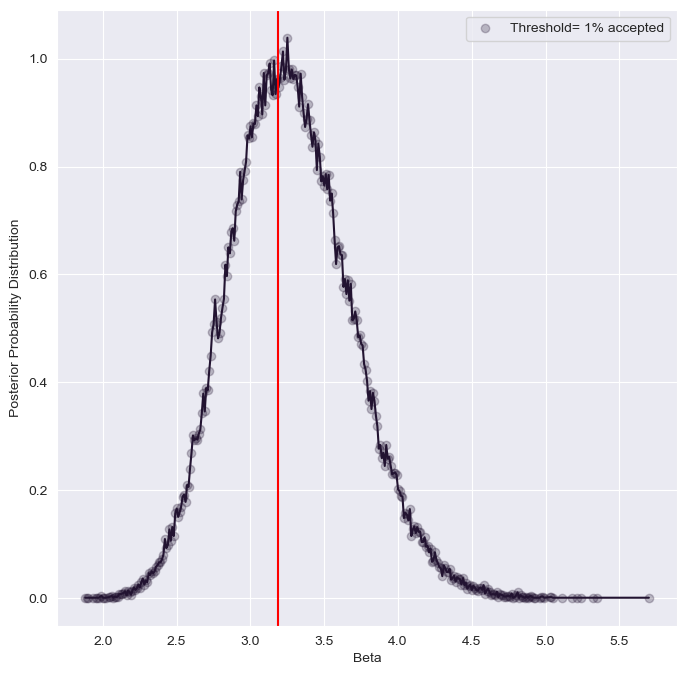

In [126]:
fig, ax0 = plt.subplots(figsize=(8, 8))
cols = sns.color_palette("rocket", n_colors=10)
for i in range(len(threshold_schedule)):
    thresh = ABC_rejection(threshold_schedule[i], graph_ABC)
    ploted = pd.DataFrame(thresh, columns=["Beta", "Counts"])
    bet_dis = ploted.groupby("Beta").count()
    plot_bet_dis = bet_dis[bet_dis["Counts"] != 0]
    max_scale = max(plot_bet_dis["Counts"])
    plot_bet_dis["Counts"] = plot_bet_dis["Counts"] / max_scale
    area = np.trapz(plot_bet_dis["Counts"],dx=0.01)
    plot_bet_dis["Counts"] = plot_bet_dis["Counts"] / area
    spline = sp.interpolate.CubicSpline(plot_bet_dis.index, plot_bet_dis["Counts"])
    print(spline)
    ax0.scatter(bet_dis.index, plot_bet_dis["Counts"], label=f"Threshold= {reference[i]}% accepted", color=cols[i],
                alpha=0.25)
    ax0.plot(plot_bet_dis.index, spline(plot_bet_dis.index), color=cols[i])
mles = np.genfromtxt("../../Data/R0_3/Fitted/MLE_b_3.csv")
mle1 = mles[0]
ax0.set_ylabel("Posterior Probability Distribution")
ax0.set_xlabel("Beta")
ax0.axvline(mle1, color="red")
ax0.legend(bbox_to_anchor=(1, 1))
#ax0.set_ylim(0, 1.1)
#ax0.set_xlim(1,5)
fig.show()

In [157]:
print(max(plot_bet_dis["Counts"]))

1.038672806968873


In [128]:
sample_cum = plot_bet_dis.copy()
sample_cum["Cum_prob"] = 0
for i in range(len(sample_cum.index)):
    sample_cum.iloc[i,1] = np.trapz(plot_bet_dis.iloc[0:i+1,0],dx=0.01)
print(sample_cum)

       Counts  Cum_prob
Beta                   
1.88  0.00111  0.000000
1.89  0.00111  0.000011
1.90  0.00111  0.000022
1.93  0.00111  0.000033
1.95  0.00111  0.000044
...       ...       ...
5.21  0.00111  0.999956
5.24  0.00111  0.999967
5.32  0.00111  0.999978
5.35  0.00111  0.999989
5.70  0.00111  1.000000

[315 rows x 2 columns]


C:\Users\ollie\AppData\Local\Temp\ipykernel_3712\336837526.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


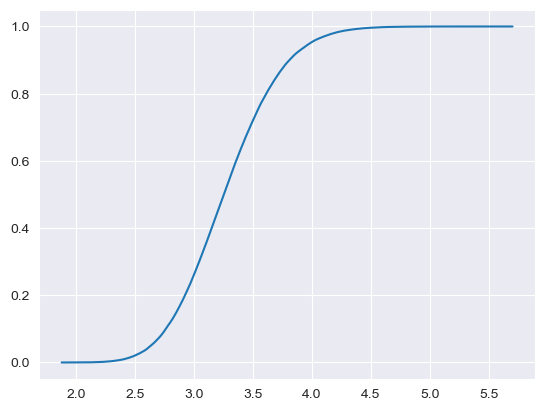

In [129]:
fig, ax0 = plt.subplots()
ax0.plot(sample_cum.index,sample_cum["Cum_prob"])
fig.show()

In [130]:
a=np.array([1,1])
b=a
b = b -1
a ==b

array([False, False])

In [147]:
def beta_sampler(beta,cum_probs,rng,size):
    out = []
    rng = rng
    for i in range(size):
        copy_cums = cum_probs
        rn = np.random.uniform()
        filtered = copy_cums - rn
        filtered[filtered<0] = 1.1
        upper = np.argmin(filtered)
        lower = upper -1
        prob_distance = copy_cums[upper] - copy_cums[lower]
        beta_distance = beta[upper] - beta[lower]
        length_along_probs = (rn-copy_cums[lower])/prob_distance
        sampled_beta = beta[lower] + length_along_probs*beta_distance
        out.append(sampled_beta)
    return out

In [148]:
rng = np.random.default_rng(1912)

In [149]:
np.array(sample_cum.index)

array([1.88, 1.89, 1.9 , 1.93, 1.95, 1.96, 1.97, 1.99, 2.  , 2.01, 2.02,
       2.04, 2.05, 2.06, 2.07, 2.08, 2.09, 2.1 , 2.11, 2.12, 2.13, 2.14,
       2.15, 2.16, 2.17, 2.18, 2.19, 2.2 , 2.21, 2.22, 2.23, 2.24, 2.25,
       2.26, 2.27, 2.28, 2.29, 2.3 , 2.31, 2.32, 2.33, 2.34, 2.35, 2.36,
       2.37, 2.38, 2.39, 2.4 , 2.41, 2.42, 2.43, 2.44, 2.45, 2.46, 2.47,
       2.48, 2.49, 2.5 , 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58,
       2.59, 2.6 , 2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69,
       2.7 , 2.71, 2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8 ,
       2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9 , 2.91,
       2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.  , 3.01, 3.02,
       3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.1 , 3.11, 3.12, 3.13,
       3.14, 3.15, 3.16, 3.17, 3.18, 3.19, 3.2 , 3.21, 3.22, 3.23, 3.24,
       3.25, 3.26, 3.27, 3.28, 3.29, 3.3 , 3.31, 3.32, 3.33, 3.34, 3.35,
       3.36, 3.37, 3.38, 3.39, 3.4 , 3.41, 3.42, 3.

In [160]:
trial_sample = beta_sampler(np.array(sample_cum.index),np.array(sample_cum["Cum_prob"]),rng,100000)

C:\Users\ollie\AppData\Local\Temp\ipykernel_3712\2677578559.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


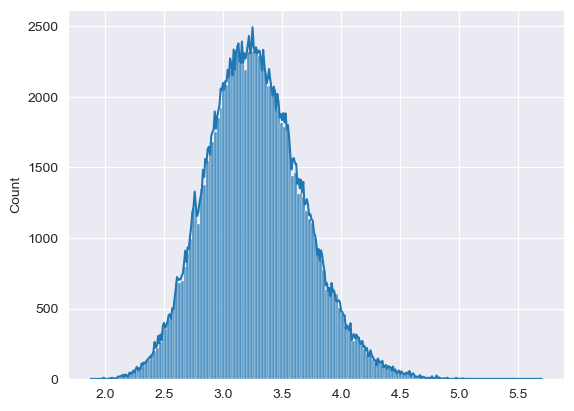

In [164]:
fig, ax0 = plt.subplots()
sns.histplot(trial_sample,ax=ax0)
ax0.plot(plot_bet_dis.index, spline(plot_bet_dis.index)*2400)
fig.show()